In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr

from pointprocess import *
import pointprocess.plotting as pplot
from lightning_setup import *
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
c = Region(city=cities['cedar'])
c.SUBSETTED = False
c.CENTER = (37.7, -111.8)
c.RADIUS = 0.7
c.define_grid(step=1, units='km')

In [6]:
storm = '2011-08-21'

In [7]:
from titan import *
fname = './input/{storm}.txt'.format(storm=storm)
titan_df = read_TITAN(fname)

In [9]:
ds = c.get_daily_ds(storm, filter_CG=dict(method='CG'))

In [10]:
# slice according to the titan times
box, tr = c.get_grid_slices(ds, tr=titan_df.index)
tr = tr[1:]

In [11]:
def Equation_19(box):
    # total number of time periods
    n1 = box.shape[0]

    # total number of grids
    n2 = box.shape[1] * box.shape[2]

    # sum of counts over all the grid cells divided by n2
    A = box.sum(axis=(1,2))/n2

    # sum of counts over all the timesteps divided by n1
    B = box.sum(axis=0).flatten()/n1

    # 1 over sum of counts divided by n1 and n2
    C = 1/(box.sum()/n1/n2)

    # control lambda of k, l
    lambda_k_l = np.outer(A, B)*C
    
    return lambda_k_l

def Equation_18(box):
    lambda_k_l = Equation_19(box)
    return ((box - lambda_k_l.reshape(box.shape))**2).sum()

In [12]:
%%time
Equation_18(box)

CPU times: user 25.5 ms, sys: 105 ms, total: 131 ms
Wall time: 130 ms


3459.6552595380917

How to minimize a function using scipy

In [75]:
import scipy.optimize as optimize

def f(c):
    return np.sqrt(c[0]**2 + c[1]**2 + c[2]**2)

result = optimize.minimize(f, [2,1,2])
print(result)

      fun: 1.0870175380483847e-08
 hess_inv: array([[  5.00000028e-01,  -5.43388051e-09,  -4.99999984e-01],
       [ -5.43388053e-09,   3.21899710e-08,   2.46385066e-08],
       [ -4.99999984e-01,   2.46385065e-08,   5.00000004e-01]])
      jac: array([ 0.25916438, -0.1799024 ,  0.25916442])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 582
      nit: 4
     njev: 114
   status: 2
  success: False
        x: array([ -4.13299130e-09,  -9.16501410e-09,  -4.13299073e-09])


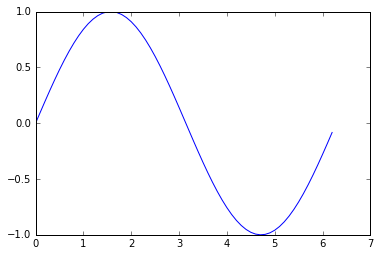

In [103]:
x = np.arange(0,np.pi*2, .1)
plt.plot(x, np.sin(x))

In [110]:
def f(x):
    return np.sin(x)
optimize.minimize_scalar(f, method='bounded', bounds=(0, 2*np.pi))

     fun: -0.9999999999991519
 message: 'Solution found.'
    nfev: 9
  status: 0
 success: True
       x: 4.7123876779706997

In [49]:
[col for col in titan_df.columns if 'max' in col.lower()]

['MaxDBZ(dBZ)',
 'MaxDBZGradient(dBZ/km)',
 'HtOfMaxDBZ(km)',
 'VilFromMaxZ(kg/m2)',
 'DdBzMax/Dt(dBZ/hr)']

In [58]:
mini_df = titan_df[['EnvelopeArea(km2)', 'ReflCentroidLat(deg)', 'ReflCentroidLon(deg)', 'MaxDBZ(dBZ)']]
mini_df.columns = ['Ai', 'lat', 'lon', 'Z1']

In [59]:
# if lat, lon are within bounds, get the grid cell they fall in.
def func(x, grid_lon):
    if x<grid_lon[-1] and x>grid_lon[0]:
        return np.argmax(grid_lon>x)
    else:
        return None
    
mini_df = mini_df.assign(x=mini_df.lon.apply(func, grid_lon=c.gridx),
                         y=mini_df.lat.apply(func, grid_lon=c.gridy))

In [60]:
xx, yy = np.meshgrid(c.gridx[1:], c.gridy[1:])
xx = xx.flatten()
yy = yy.flatten()

In [61]:
mini_df = mini_df.assign(l=((mini_df.y-1)*(box.shape[2])+(mini_df.x)-1))
mini_df.head()

,Ai,lat,lon,Z1,x,y,l
date_time,,,,,,,
2011-08-21 18:10:20,4,38.2054,-111.485,48.4944,90.0,86.0,10629.0
2011-08-21 18:13:28,6,38.2083,-111.477,47.4992,91.0,86.0,10630.0
2011-08-21 18:16:37,7,38.2125,-111.477,50.6413,91.0,87.0,10754.0
2011-08-21 18:19:58,6,38.2181,-111.474,48.9443,91.0,87.0,10754.0
2011-08-21 18:23:06,2,38.2243,-111.471,46.5974,91.0,87.0,10754.0
